## Loading Dataset

In [2]:
import psycopg2
import pandas as pd
import numpy as np
import seaborn as sns
from  scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from pitchfork_functions import query_to_df, sample_size_calc, bootstrap_mean_stats, two_sample_ttest_stats
%matplotlib inline
conn = psycopg2.connect("dbname=musicdatabase")
cur = conn.cursor()

#### Loading SQLite into PostGreSQL:
Our original source file was a sqlite file which we wanted to load into PostGreSQL to be able to work safely locally and not rely on the original file.  We did so through the command line with the help of pgloader.  The steps we took were:
* Installing pgloader:  
    ```brew install pgloader```
* Creating our local database:  
    ```CREATEDB msuicdatabase```
* Executing pgloader:  
   ```pgloader music.sqlite postgresql:///musicdatabase```

## Creating DataFrames

In [3]:
# Genre table
genres_df = query_to_df("SELECT * FROM genres")

# Artists table
artists_df = query_to_df("SELECT * FROM artists")

# Content table
content_df = query_to_df("SELECT * FROM content")

# Labels table
labels_df = query_to_df("SELECT * FROM labels")

# Reviews table
reviews_df = query_to_df("SELECT * FROM reviews")

#Years table
years_df = query_to_df("SELECT * FROM years")


## Exploring the Data

In [4]:
print('genre df length: ', len(genres_df))
print('artists df length: ', len(artists_df))
print('content df length: ', len(content_df))
print('labels df length: ', len(labels_df))
print('reviews df length: ', len(reviews_df))
print('years df length: ', len(years_df))

genre df length:  22680
artists df length:  18831
content df length:  18393
labels df length:  20190
reviews df length:  18393
years df length:  19108


In [5]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18393 entries, 0 to 18392
Data columns (total 13 columns):
reviewid          18393 non-null int64
title             18393 non-null object
artist            18393 non-null object
url               18393 non-null object
score             18393 non-null float64
best_new_music    18393 non-null int64
author            18393 non-null object
author_type       14487 non-null object
pub_date          18393 non-null object
pub_weekday       18393 non-null int64
pub_day           18393 non-null int64
pub_month         18393 non-null int64
pub_year          18393 non-null int64
dtypes: float64(1), int64(6), object(6)
memory usage: 1.8+ MB


In [6]:
reviews_df.isna().sum()
#no NANs in column 1.. however 2367 in column 2

reviewid             0
title                0
artist               0
url                  0
score                0
best_new_music       0
author               0
author_type       3906
pub_date             0
pub_weekday          0
pub_day              0
pub_month            0
pub_year             0
dtype: int64

## Seeing Which Tables Have Multiple Rows Per Song

In [10]:
labels_df.loc[labels_df['reviewid'] == 2626]
#example, song 6523 has 4 artists

,reviewid,label
14612,2626,cleopatra
14613,2626,alternative tentacles
14614,2626,manifesto
14615,2626,cherry red
14616,2626,irs


In researching our data, we found that many tables had multiple genres and labels per album.

In [11]:
reviews_df.loc[reviews_df['reviewid']==2626]

,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year
13198,2626,fresh fruit for rotting vegetables,dead kennedys,http://pitchfork.com/reviews/albums/2626-fresh...,7.0,0,cory d. byrom,None,2005-11-09,2,9,11,2005


* Review Table -- has 4 songs that have 2 reviewid's... i believe this is an error as all rows are identical
* Content Table -- also has 4 songs with 2 reviewid's... will remove the duplicated rows
* Genres Tabel -- Many songs have 2+ genres
* Labels Tabel -- Many songs have 2+ labels
* Artists Tabel -- Many songs have 2+ artists
* Year Tabel -- Many songs have 2+ release years... this may be an error... considering keeping only oldest year

In [12]:
labels_df['reviewid'].value_counts().head(10)

2626     5
21550    5
21387    4
17112    4
9505     4
17920    4
16092    4
16384    4
22065    4
22567    3
Name: reviewid, dtype: int64

## Combining Genre and Review Tables

Since we have albums that are listed under multiple genres, we needed to one hot encode our genres and then connect that data to our album table.

In [47]:
genres_one_hot = pd.get_dummies(genres_df['genre'])
genres_hot_df = pd.concat([genres_df, genres_one_hot], axis = 1)
genres_hot_df.drop('genre', axis=1, inplace=True)
genres_hot_df.head()

,reviewid,electronic,experimental,folk/country,global,jazz,metal,pop/r&b,rap,rock
0,22703,1,0,0,0,0,0,0,0,0
1,22721,0,0,0,0,0,1,0,0,0
2,22659,0,0,0,0,0,0,0,0,1
3,22661,0,0,0,0,0,0,0,0,1
4,22725,1,0,0,0,0,0,0,0,0


Second, we filtered our genres table for only 

In [48]:
pop_elec_genres = genres_hot_df.loc[((genres_hot_df['pop/r&b'] == 1) | (genres_hot_df['electronic'] == 1)),
                                   ['reviewid', 'electronic', 'pop/r&b']]
pop_elec_genres.head()

,reviewid,electronic,pop/r&b
0,22703,1,0
4,22725,1,0
7,22694,1,0
12,22700,1,0
18,22719,0,1


Third, add value_count column in order to remove any albums that fall under both electronic & pop.

In [49]:
genre_counts = pop_elec_genres['reviewid'].value_counts()
genre_dict = genre_counts.to_dict()
pop_elec_genres['value_count'] = genres_hot_df_filtered['reviewid'].apply(lambda x: genre_dict[x])
pop_elec_genres.head()

,reviewid,electronic,pop/r&b,value_count
0,22703,1,0,1
4,22725,1,0,1
7,22694,1,0,1
12,22700,1,0,1
18,22719,0,1,1


Remove albums with both electronic and pop (where value_counts = 2)

In [50]:
albums_to_drop = pop_elec_genres[pop_elec_genres['value_count'] >= 2]
pop_elec_genre_df = pop_elec_genres.drop(genre_to_drop.index, axis=0)

In [52]:
pop_elec_genre_df.head()

,reviewid,electronic,pop/r&b,value_count
0,22703,1,0,1
4,22725,1,0,1
7,22694,1,0,1
12,22700,1,0,1
18,22719,0,1,1


Merge the new Genre Table with the existing Review Table

In [53]:
rg_df = reviews_df.merge(pop_elec_genre_df, left_on='reviewid', right_on='reviewid')
rg_df.head()

,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year,electronic,pop/r&b,value_count
0,22703,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,8,1,2017,1,0,1
1,22725,new start,taso,http://pitchfork.com/reviews/albums/22725-new-...,8.1,0,kevin lozano,tracks coordinator,2017-01-06,4,6,1,2017,1,0,1
2,22694,tehillim,yotam avni,http://pitchfork.com/reviews/albums/22694-tehi...,7.0,0,andy beta,contributor,2017-01-05,3,5,1,2017,1,0,1
3,22700,nadir,steven warwick,http://pitchfork.com/reviews/albums/22700-nadir/,7.6,0,thea ballard,contributor,2017-01-03,1,3,1,2017,1,0,1
4,22719,merry christmas lil mama,"chance the rapper, jeremih",http://pitchfork.com/reviews/albums/22719-merr...,8.1,0,sheldon pearce,associate staff writer,2016-12-30,4,30,12,2016,0,1,1


## Hypothesis Test #1 
* Null: There is no statistically significant difference between the reviews for Pop/R&B albums and Electronic music albums.
* Alternative: The reviews for Pop/R&B albums and Electronic albums have a statistically significant difference between how they are reviewed, either positively or negatively. 

In [54]:
pop_df = rg_df[rg_df['pop/r&b'] == 1].copy()
elec_df = rg_df[rg_df['electronic'] == 1].copy()

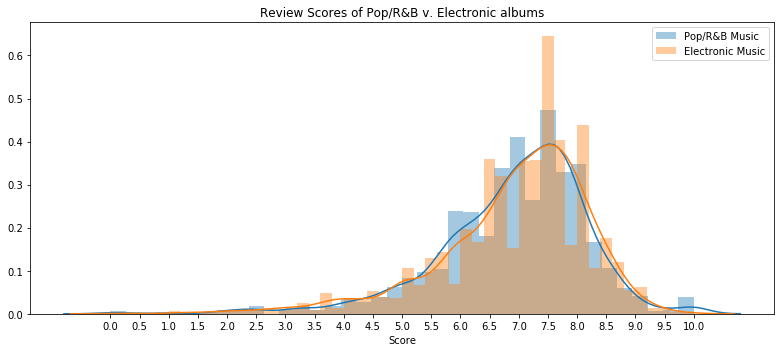

In [62]:
plt.figure(figsize=(11,5))
sns.distplot(pop_df['score'], label="Pop/R&B Music")
sns.distplot(elec_df['score'], label="Electronic Music")
plt.title("Review Scores of Pop/R&B v. Electronic albums")
plt.xlabel('Score')
plt.xticks(np.arange(0,10.5, .5))
plt.tight_layout()
plt.legend()
plt.show();

In [63]:
# Created a helper function for Two Sample T-Test for our categorical comparissions.
two_sample_ttest_stats(pop_df['score'], elec_df['score'])

Sample 1 Review Mean:  6.918853820598006
Sampe 2 Review Mean:  6.934585847504114
Difference:  -0.01573202690610831
T-Statistic: -0.36421091026425517
P-Value: 0.7157164040794012


#### Bootstrap Check
We further performed bootstrap sampling on our data, to see if the values we arrived at are in line with what we might find from other samples of this data. 

##### Finding Appropriate Sample Size

In [22]:
# Using sample size calculation converted into a function
sample_size_calc(pop_df['score'],elec_df['score'], moe=.5)

87.64595381733723

Appropriate sample size must be greater than 87.6

In [23]:
samp_size = 90

In [64]:
std, low_p, high_p = bootstrap_mean_stats(pop_df['score'], sample_size=90, n_tests=100)
print(f"Pop Sample Means Stdv: {std}\nPop 2.5 Percentile: {low_p}\nPop 97.5 Percentile: {high_p}")

Pop Sample Means Stdv: 0.1294
Pop 2.5 Percentile: 6.6844
Pop 97.5 Percentile: 7.1721


In [65]:
std, low_p, high_p = bootstrap_mean_stats(elec_df['score'], sample_size=90, n_tests=100)
print(f"Elec Sample Means Stdv: {std}\nElec 2.5 Percentile: {low_p}\nElec 97.5 Percentile: {high_p}")

Elec Sample Means Stdv: 0.1474
Elec 2.5 Percentile: 6.6443
Elec 97.5 Percentile: 7.1939


#### Summary: Hypothesis #1

Through our exploration, we found there to be very little variability between the rating of the two genres. We found a p-value of .716, which far exceeds our threshold of .05, telling us that we must accept our null hypothesis that there is not a statistically significant difference between the rating of Pop/R&B and Electronic albums.

In our further bootstrap test, sampling our data, we did not find significant variability in the performance of our two groups.

## Hypothesis Test #2
* Null: In sampling the 500 worst and 500 best reviewed albums, there is no statistically significant difference in the genres each represents with regards to score. 
* Alternative: The 500 worst reviewed and 500 best reviewed albums have a statistically significant difference in the genres they have. 

### 500 Best Rated Albums

In [101]:
query = """
SELECT 
    reviewid
,   score
,   author
,   author_type
FROM 
    reviews
ORDER BY 
    score DESC
LIMIT 500;
"""

cur = conn.cursor()
cur.execute(query)
names = [description[0] for description in cur.description]
best_100 = pd.DataFrame(cur.fetchall(),columns=names)
best_wgenres = genres_hot_df.merge(best_100, on='reviewid')
best_wgenres.head()

,reviewid,electronic,experimental,folk/country,global,jazz,metal,pop/r&b,rap,rock,score,author,author_type
0,22703,1,0,0,0,0,0,0,0,0,9.3,nate patrin,contributor
1,22661,0,0,0,0,0,0,0,0,1,9.0,jenn pelly,associate reviews editor
2,22707,0,0,0,0,1,0,0,0,0,9.0,seth colter-walls,contributor
3,22643,0,0,0,0,0,0,0,0,1,9.3,jesse jarnow,contributor
4,22555,1,0,0,0,0,0,0,0,0,9.5,andy beta,contributor


### 500 Worst Rated Albums

In [102]:
query = """
SELECT 
    reviewid
,   score
,   author
,   author_type
FROM 
    reviews
ORDER BY 
    score ASC
LIMIT 500;
"""

cur = conn.cursor()
cur.execute(query)
names = [description[0] for description in cur.description]
worst_100 = pd.DataFrame(cur.fetchall(),columns=names)
worst_wgenres = genres_hot_df.merge(worst_100, on='reviewid')
worst_wgenres.head()

,reviewid,electronic,experimental,folk/country,global,jazz,metal,pop/r&b,rap,rock,score,author,author_type
0,22720,0,0,0,0,0,0,0,1,0,3.5,marcus j. moore,contributor
1,22589,1,0,0,0,0,0,0,0,0,3.5,kevin lozano,tracks coordinator
2,22319,0,0,0,0,0,0,0,0,1,2.0,ian cohen,contributor
3,22319,0,0,0,0,0,0,0,1,0,2.0,ian cohen,contributor
4,22143,1,0,0,0,0,0,0,0,0,2.5,stacey anderson,associate features editor


In [103]:
# Correcting column names for use in ANOVA test
best_wgenres.rename(columns={'pop/r&b': 'pop_rb', 'folk/country': 'folk_country'}, inplace=True)
worst_wgenres.rename(columns={'pop/r&b': 'pop_rb', 'folk/country': 'folk_country'}, inplace=True)

In [104]:
formula = """score ~ C(rock) + C(electronic) + C(rap) + C(metal) 
            + C(experimental) +C(jazz) + C(pop_rb) + C(folk_country)"""
lm = ols(formula, best_wgenres).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                    sum_sq     df          F    PR(>F)
C(rock)           0.407402    1.0   3.708124  0.054633
C(electronic)     0.018879    1.0   0.171834  0.678639
C(rap)            0.544781    1.0   4.958531  0.026342
C(metal)          0.062107    1.0   0.565292  0.452438
C(experimental)   0.019272    1.0   0.175411  0.675500
C(jazz)           0.157476    1.0   1.433328  0.231707
C(pop_rb)         1.148879    1.0  10.456954  0.001291
C(folk_country)   0.019713    1.0   0.179424  0.672025
Residual         64.272491  585.0        NaN       NaN


Looking at the P-values of our ANOVA test, we found that those albums appearing in the top 500 reviewed albums that received higher scores appeared to be highly correlated to being either Pop/R&B or Rap (with Rock being very close as well).

### Creating ANOVA tables for Worst rated songs:

In [105]:
formula = """score ~ C(rock) + C(electronic) + C(rap) + C(metal) 
            + C(experimental) +C(jazz) + C(pop_rb) + C(folk_country)"""
lm = ols(formula, worst_wgenres).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                     sum_sq     df         F    PR(>F)
C(rock)            0.172404    1.0  0.225969  0.634690
C(electronic)      1.091531    1.0  1.430664  0.232096
C(rap)             0.101879    1.0  0.133532  0.714918
C(metal)           0.023072    1.0  0.030241  0.862000
C(experimental)    0.146514    1.0  0.192035  0.661375
C(jazz)            0.686205    1.0  0.899406  0.343297
C(pop_rb)          0.126617    1.0  0.165956  0.683867
C(folk_country)    0.556711    1.0  0.729678  0.393305
Residual         491.342202  644.0       NaN       NaN


For our ANOVA test on the worst rated albums, we did not find any genre with a statisttically significant relation to the score they received.  This being said, it would appear that bad albums are considered such, and there is potentially no bias for this based genre.

Based on these results, we decided to drill more into the reviewers and how they scored.  Here is a brief digression into the scoring of top 500 reviews by the author type:

#### Creating encoding for review by author type:

In [107]:
# Create reviewer types
reviewer = list(best_wgenres['author_type'].value_counts().index)

rev_names = {}
for r in reviewer:
    rev_names[r] = r.replace(" ","_")
rev_names

{'contributor': 'contributor',
 'executive editor': 'executive_editor',
 'senior editor': 'senior_editor',
 'editor-in-chief': 'editor-in-chief',
 'contributing editor': 'contributing_editor',
 'associate reviews editor': 'associate_reviews_editor',
 'senior staff writer': 'senior_staff_writer',
 'deputy news editor': 'deputy_news_editor'}

In [108]:
# Performing manual one hot encoding on reviews by author type:
for old, new in rev_names.items():
    best_wgenres[new] = best_wgenres['author_type'].apply(lambda x: 1 if x == old else 0)
    worst_wgenres[new] = worst_wgenres['author_type'].apply(lambda x: 1 if x == old else 0)

In [ ]:
best_wgenres.rename(columns={'editor-in-chief':'ec'}, inplace=True)
worst_wgenres.rename(columns={'editor-in-chief':'ec'}, inplace=True)

####  ANOVA Table for author type by review score: Best scores

In [110]:
formula = """score ~ C(contributor) + C(executive_editor) + C(senior_editor) 
            + C(ec) + C(contributing_editor) + C(associate_reviews_editor) 
            + C(senior_staff_writer) + C(deputy_news_editor)"""
lm = ols(formula, best_wgenres).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                                sum_sq     df         F    PR(>F)
C(contributor)                0.099847    1.0  0.895279  0.344441
C(executive_editor)           0.632875    1.0  5.674655  0.017530
C(senior_editor)              0.080004    1.0  0.717355  0.397359
C(ec)                         0.200698    1.0  1.799553  0.180287
C(contributing_editor)        0.066484    1.0  0.596123  0.440373
C(associate_reviews_editor)   0.277094    1.0  2.484554  0.115510
C(senior_staff_writer)        0.099482    1.0  0.892007  0.345324
C(deputy_news_editor)         0.047042    1.0  0.421799  0.516296
Residual                     65.243010  585.0       NaN       NaN


#### ANOVA Table for author type by review score: Worst scores

In [158]:
formula = """score ~ C(contributor) + C(executive_editor) + C(senior_editor) 
            + C(ec) + C(senior_staff_writer)"""
worst = ols(formula, worst_wgenres).fit()
table = sm.stats.anova_lm(worst, typ=2)
print(table)

                            sum_sq     df         F    PR(>F)
C(contributor)            0.207015    1.0  0.273110  0.601432
C(executive_editor)       0.398292    1.0  0.525460  0.468784
C(senior_editor)          0.463840    1.0  0.611935  0.434346
C(ec)                     2.182150    1.0  2.878869  0.090230
C(senior_staff_writer)    0.470435    1.0  0.620636  0.431099
Residual                490.418612  647.0       NaN       NaN


#### Summary: Hypothesis #2

Based on the results of our ANOVA test, we were able to reject our null hypothesis and say that there is a statistically significant difference between how genres are scored between the top 500 rated albums and the worst 500 rated albums.  Pop/R&B and Rap albums appear to be correlated to higher scores within the top 500 rated albums. To further look into this, we can see that part of the reason may be that there are so few albums of these genres are actually represented in the top 500. 

In [106]:
print(f""" Percent of Top 500 Rap or Pop/R&B: {round((((len(best_wgenres[best_wgenres['rap'] == 1]) +
 len(best_wgenres[best_wgenres['pop_rb'] == 1])) / best_wgenres.shape[0]) * 100), 2)}% """)

 Percent of Top 500 Rap or Pop/R&B: 10.77% 


In reviewing scores by author type, there does seem to be some correlation between the Executive Editor and the score those in the top 500 receive.  This could be understood as that position getting the best assignments that come in based on their musical knowledge, but with this showing significance, it seemed worth looking into how different reviewers score albums.  

## Hypothesis Test #3
* Null Hypothesis: There is no statistical difference between the top reviewers (5 reviewers who scored the most albums) scores between genres.
* Alternative: There is a statistical difference between the top reviewers (5 reviewers who scored the most albums) scores between genres.

In [169]:
# Value count of authors in review df, clip top 5
author_reviews_df = reviews_df.copy()

author_dict = reviews_df['author'].value_counts().to_dict()
author_reviews_df['author_review_count'] = author_reviews_df['author'].apply(lambda x: author_dict[x])
author_reviews_df['>200_reviews'] = author_reviews_df['author_review_count'].apply(lambda x: 1 if x >199 else 0)
author_reviews_df.head()

,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year,author_review_count,>200_reviews
0,22703,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,8,1,2017,347,1
1,22721,prelapsarian,krallice,http://pitchfork.com/reviews/albums/22721-prel...,7.9,0,zoe camp,contributor,2017-01-07,5,7,1,2017,69,0
2,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017,4,0
3,22661,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,1,jenn pelly,associate reviews editor,2017-01-06,4,6,1,2017,41,0
4,22725,new start,taso,http://pitchfork.com/reviews/albums/22725-new-...,8.1,0,kevin lozano,tracks coordinator,2017-01-06,4,6,1,2017,51,0


In [170]:
author_to_drop = author_reviews_df[author_reviews_df['>200_reviews'] < 1]
author_reviews_df = author_reviews_df.drop(author_to_drop.index, axis=0)
author_reviews_df.head()

,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year,author_review_count,>200_reviews
0,22703,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,8,1,2017,347,1
7,22694,tehillim,yotam avni,http://pitchfork.com/reviews/albums/22694-tehi...,7.0,0,andy beta,contributor,2017-01-05,3,5,1,2017,250,1
8,22714,reflection,brian eno,http://pitchfork.com/reviews/albums/22714-refl...,7.7,0,andy beta,contributor,2017-01-04,2,4,1,2017,250,1
9,22724,filthy america its beautiful,the lox,http://pitchfork.com/reviews/albums/22724-filt...,5.3,0,ian cohen,contributor,2017-01-04,2,4,1,2017,699,1
10,22715,clear sounds/perfetta,harry bertoia,http://pitchfork.com/reviews/albums/22715-clea...,8.0,0,marc masters,contributor,2017-01-04,2,4,1,2017,312,1


In [171]:
authors_one_hot = pd.get_dummies(author_reviews_df['author'])
authors_hot_df = pd.concat([author_reviews_df, authors_one_hot], axis = 1)
authors_hot_df.head()

,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,...,mark richardson,matthew murphy,nate patrin,nick neyland,paul thompson,philip sherburne,rob mitchum,stephen m. deusner,stuart berman,tom breihan
0,22703,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,...,0,0,1,0,0,0,0,0,0,0
7,22694,tehillim,yotam avni,http://pitchfork.com/reviews/albums/22694-tehi...,7.0,0,andy beta,contributor,2017-01-05,3,...,0,0,0,0,0,0,0,0,0,0
8,22714,reflection,brian eno,http://pitchfork.com/reviews/albums/22714-refl...,7.7,0,andy beta,contributor,2017-01-04,2,...,0,0,0,0,0,0,0,0,0,0
9,22724,filthy america its beautiful,the lox,http://pitchfork.com/reviews/albums/22724-filt...,5.3,0,ian cohen,contributor,2017-01-04,2,...,0,0,0,0,0,0,0,0,0,0
10,22715,clear sounds/perfetta,harry bertoia,http://pitchfork.com/reviews/albums/22715-clea...,8.0,0,marc masters,contributor,2017-01-04,2,...,0,0,0,0,0,0,0,0,0,0


In [172]:
# Is this duplicate?
genre_count = genres_hot_df['reviewid'].value_counts().to_dict()
genres_hot_df['genre_count'] = genres_hot_df['reviewid'].apply(lambda x: genre_count[x])
genres_hot_df.head()

,reviewid,electronic,experimental,folk/country,global,jazz,metal,pop/r&b,rap,rock,genre_count
0,22703,1,0,0,0,0,0,0,0,0,1
1,22721,0,0,0,0,0,1,0,0,0,1
2,22659,0,0,0,0,0,0,0,0,1,1
3,22661,0,0,0,0,0,0,0,0,1,1
4,22725,1,0,0,0,0,0,0,0,0,1


In [173]:
#rg2 = review & genres v2
rg2_df = authors_hot_df.merge(genres_hot_df, left_on='reviewid', right_on='reviewid')

In [174]:
#Each genre for authors with >200 reviews:
elec_df = rg2_df[(rg2_df['electronic'] == 1) & (rg2_df['>200_reviews'] == 1)]
pop_df = rg2_df[(rg2_df['pop/r&b'] == 1) & (rg2_df['>200_reviews'] == 1)]

In [203]:
# NEED TO GET THESE VALUES FOR POP ELEC!

#Each of the top 5 authors by each of the 9 categories:
#joe tangari .  ian cohen .  stephen m. deusner .  brian howe .  mark richardson . 
rock_df_joe = rock_df[(rock_df['author'] == 'joe tangari')]
rock_df_ian = rock_df[(rock_df['author'] == 'ian cohen')]
rock_df_stephen = rock_df[(rock_df['author'] == 'stephen m. deusner')]
rock_df_brian = rock_df[(rock_df['author'] == 'brian howe')]
rock_df_mark = rock_df[(rock_df['author'] == 'mark richardson')]

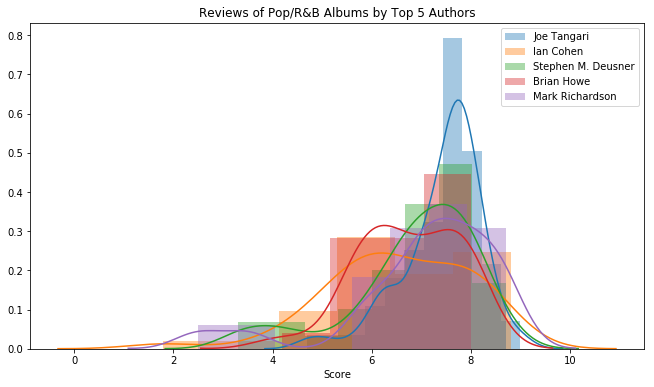

In [176]:
authors = ['joe tangari', 'ian cohen', 'stephen m. deusner', 'brian howe', 'mark richardson']
poprb_df = rg2_df[(rg2_df['pop/r&b'] == 1) & (rg2_df['>200_reviews'] == 1)]

plt.figure(figsize=(11,6))
for name in authors:
    sns.distplot(poprb_df.loc[poprb_df['author'] == name, 'score'], label=name.title(), hist=True, kde=True)
plt.title("Reviews of Pop/R&B Albums by Top 5 Authors")
plt.xlabel("Score")
plt.legend()
plt.show();

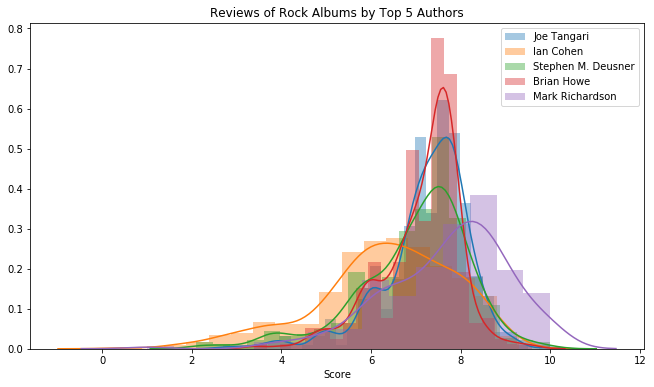

In [177]:
rock_df = rg2_df[(rg2_df['rock'] == 1) & (rg2_df['>200_reviews'] == 1)]

plt.figure(figsize=(11,6))
for name in authors:
    sns.distplot(rock_df.loc[rock_df['author'] == name, 'score'], label=name.title(), hist=True, kde=True)
plt.title("Reviews of Rock Albums by Top 5 Authors")
plt.xlabel("Score")
plt.legend()
plt.show();

In [188]:
authors = ['joe tangari', 'ian cohen', 'stephen m. deusner', 'brian howe', 'mark richardson']
for name in authors:
    print(f"Mean score - {name.title()}: {round(rock_df.loc[rock_df['author'] == name, 'score'].mean(), 3)}")

Mean score - Joe Tangari: 7.234
Mean score - Ian Cohen: 6.332
Mean score - Stephen M. Deusner: 6.967
Mean score - Brian Howe: 7.128
Mean score - Mark Richardson: 7.698


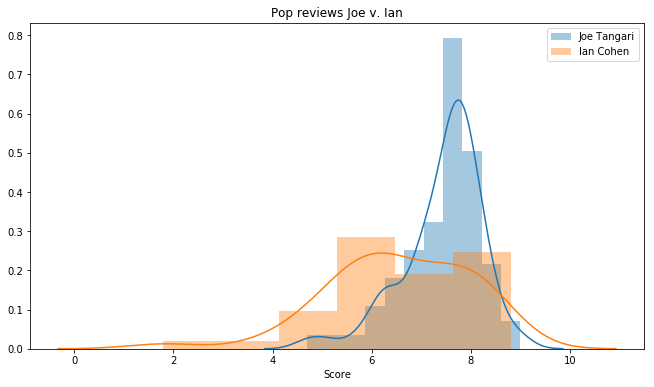

In [204]:
plt.figure(figsize=(11,6))

sns.distplot(pop_df.loc[pop_df['author'] == 'joe tangari', 'score'],
                         label="Joe Tangari", hist=True, kde=True)
sns.distplot(pop_df.loc[pop_df['author'] == 'ian cohen', 'score'], 
                         label="Ian Cohen", hist=True, kde=True)
plt.title("Pop reviews Joe v. Ian")
plt.xlabel("Score")
plt.legend()
plt.show();

In [196]:
two_sample_ttest_stats(pop_df.loc[pop_df['author'] == 'joe tangari', 'score'], 
                       pop_df.loc[pop_df['author'] == 'ian cohen', 'score'])

Sample 1 Review Mean:  7.433802816901408
Sampe 2 Review Mean:  6.537777777777777
Difference:  0.8960250391236313
T-Statistic: 4.320562728882836
P-Value: 3.341563304143575e-05


In [205]:
#ELECTRIC!!! 
# plt.figure(figsize=(11,6))

# sns.distplot(rock_df_mark['score'], label="Mark Richardson", hist=True, kde=True)
# sns.distplot(rock_df_ian['score'], label="Ian Cohen", hist=True, kde=True)
# plt.title("Rock reviews Joe v. Ian")
# plt.xlabel("Score")
# plt.legend()
# plt.show();

In [206]:
# John vs. everyone
# Ian v. John
# Mark v. John
two_sample_ttest_stats(rock_df_mark['score'], rock_df_ian['score'])

Sample 1 Review Mean:  7.698039215686275
Sampe 2 Review Mean:  6.331521739130435
Difference:  1.36651747655584
T-Statistic: 10.765311854341338
P-Value: 5.138502264764509e-25


In [179]:
sample_size_calc(rock_df_joe['score'], rock_df_ian['score'], moe=0.5)

87.10752089337353

In [180]:
std, low_p, high_p = bootstrap_mean_stats(rock_df_mark['score'], sample_size=90, n_tests=100)
print(f"Mark Means Stdv: {std}\nMark 2.5 Percentile: {low_p}\nMark 97.5 Percentile: {high_p}")

Mark Means Stdv: 0.1201
Mark 2.5 Percentile: 7.4625
Mark 97.5 Percentile: 7.9402


In [181]:
std, low_p, high_p = bootstrap_mean_stats(rock_df_mark['score'], sample_size=90, n_tests=100)
print(f"Ian Means Stdv: {std}\nIan 2.5 Percentile: {low_p}\nIan 97.5 Percentile: {high_p}")

Ian Means Stdv: 0.1477
Ian 2.5 Percentile: 7.3812
Ian 97.5 Percentile: 7.9346


#### Summary: Hypothesis #3

Based on the results, we reject the null hypothesis and accept that there are certain reviewers who write more favorable reviews for different genres. In particular, Ian tends to review albums with greater variability and critic than others. Although Mark tends to score slightly higher than Joe, it is not statistically significant.   

## Hypothesis Test #4
* Null: There is no statistically significant difference between self-released album ratings and all others. 
* Alternative: Self-released albums have a statistically significant decrease in ratings compared to other labels.

In [26]:
multi_label = dict(labels_df['reviewid'].value_counts())
labels_df['label count'] = labels_df['reviewid'].apply(lambda x: multi_label[x])
labels_df.head()

,reviewid,label,label count
0,22703,virgin,1
1,22721,hathenter,1
2,22659,static shock,2
3,22659,fashionable idiots,2
4,22661,kill rock stars,2


In [27]:
to_drop = labels_df[labels_df['label count'] > 1]
label_solo_df = labels_df.drop(to_drop.index, axis=0)

In [28]:
revlab_df = reviews_df.merge(label_solo_df, left_on='reviewid', right_on='reviewid')

In [29]:
self_df = revlab_df[revlab_df['label'] == 'self-released'].copy()
label_df = revlab_df[revlab_df['label'] != 'self-released'].copy()

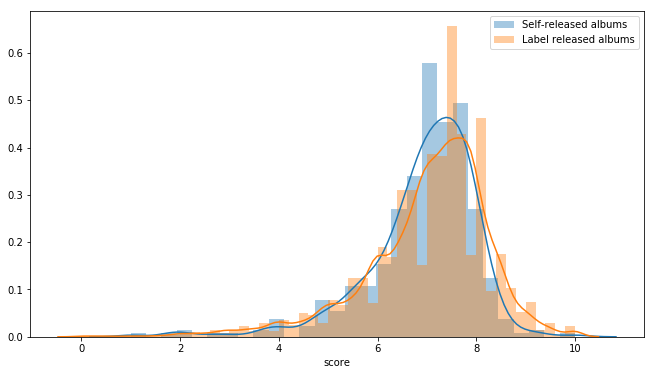

In [30]:
plt.figure(figsize=(11,6))
sns.distplot(self_df['score'], label='Self-released albums');
sns.distplot(label_df['score'], label='Label released albums');
plt.legend()
plt.show();

In [31]:
two_sample_ttest_stats(self_df['score'], label_df['score'])

Sample 1 Review Mean:  6.918181818181819
Sampe 2 Review Mean:  7.009612678210855
Difference:  -0.09143086002903633
T-Statistic: -1.4400160399176198
P-Value: 0.14988154041527244


#### Summary: Hypothesis #4

Based on the results, we accept our null hypothesis, due to our two sample t-test resulting in a P-value of .149. The review scores for both self published and label publshed do no appear to have favorable scores. 

In [209]:
# Mean difference between these categories and others
# If possible pull out Twitter stats for writers
# 
top_authors = ['joe tangari', 'ian cohen', 'stephen m. deusner', 'brian howe', 'mark richardson']
author_tw = pd.read_csv('author_twitter.csv', index_col=0)
author_tw

,followers,author,twitter
0,6142,douglas wolk,@douglaswolk
1,15309,marc masters,@Marcissist
2,4145,nate patrin,@natepatrin
3,147,joshua love,@joshcarusolove
4,734,nick neyland,@nickneyland
5,2974,stephen m. deusner,@stephenmdeusner
6,2366,andrew gaerig,@agaerig
7,3676,nick sylvester,@nickgodmode
8,14882,tom breihan,@tombreihan
9,6839,jason heller,@jason_m_heller
